In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, plot_confusion_matrix

In [ ]:
### Helper method

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
!pip install optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/PG32 CS3244/smoteNCTrain.csv')
df_test = pd.read_csv('/content/drive/MyDrive/PG32 CS3244/smoteNCTest.csv')

In [ ]:
df_train.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,0,0,0,0,135000.0,4,1,1,4,-13566,-1900,1,6,2,0
1,1,1,1,0,315000.0,4,3,3,4,-10328,-543,0,6,1,0
2,0,1,1,0,315000.0,0,1,2,4,-18184,-3021,0,8,1,0
3,0,0,1,1,180000.0,2,1,3,4,-13467,-3850,0,11,2,0
4,1,1,0,1,247500.0,4,1,1,4,-13086,-1931,0,8,3,0


In [ ]:
df_test.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,0,0,1,0,202500.0,2,1,2,4,-16834,-1692,0,11,1,0
1,1,1,0,0,675000.0,0,3,1,4,-18126,-948,0,10,2,0
2,0,0,0,0,234000.0,2,3,0,4,-21967,-5215,0,3,2,0
3,0,1,1,0,445500.0,0,3,1,4,-12477,-456,0,10,2,0
4,0,1,0,0,225000.0,4,1,1,5,-12155,-667,0,8,2,0


In [ ]:
df_train.shape

(50164, 15)

In [ ]:
df_test.shape

(21518, 15)

In [ ]:
X_train = df_train.iloc[:,1:-1] # all the variables
y_train = df_train.iloc[:,-1] # labels

X_test = df_test.iloc[:,1:-1] # all the variables
y_test = df_test.iloc[:,-1] # labels

In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(10,50,100), max_iter=300,activation = 'relu',solver='adam',learning_rate='constant',alpha=0.05)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
print(sum(y_predict == y_test))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

10881
Accuracy Score is 0.50567
Recall Score is 0.19611
Precision Score is 0.51489
F1 Score is 0.28404
      0     1
0  8771  1988
1  8649  2110


#### Model Tuning for decision tree

#### Range of Parameters

In the case of Random Forest, we generally tune the following parameters:

1. criterion
2. max_depth
3. min_samples_split
4. min_samples_leaf

Since decision tree is fast to compute, we will use grid search to find the best set of parameters instead of bayesian optimisation used in tuning other models.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import optuna
import numpy as np


def objective(trial):
  params_grid = {
      "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 9),
      "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
      "max_depth": trial.suggest_int("max_depth", 5, 50),
      "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"])
  }
  model = DecisionTreeClassifier(random_state = 42, **params_grid)
  score = cross_val_score(model, X_train, y_train, cv = 5).mean()
  return score


search_space = {"criterion": ["gini", "entropy"],
                "max_depth": np.arange(start=5, stop=50, step=2).tolist(), 
                "min_samples_leaf": np.arange(start=1, stop=10, step=2).tolist(), 
                "min_samples_split": np.arange(start=2, stop=11, step=2).tolist()
                }

Since the mean accuracy is computed by the objective function, we will set the ```direction``` to "maximize"

In [ ]:
study = optuna.create_study(direction = "maximize", sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}= {}, ".format(key, value))

15695
Accuracy Score is 0.72939
Recall Score is 0.48248
Precision Score is 0.95318
F1 Score is 0.64067
       0     1
0  10504   255
1   5568  5191
[[0.97629891 0.02370109]
 [0.51752022 0.48247978]]


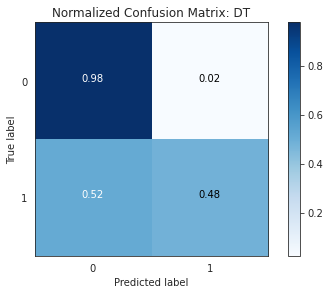

In [ ]:
from sklearn import tree
tuned_model=tree.DecisionTreeClassifier(random_state=42, 
  min_samples_leaf= 1, 
  min_samples_split= 2,
  max_depth= 35, 
  criterion= "entropy" )
tuned_model.fit(X_train, y_train)

y_predict = tuned_model.predict(X_test)
print(sum(y_predict == y_test))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: DT')

Compared with the baseline model, the tuned model has a 0.005 increase in accuracy, 0.01 increase in recall, a similar precision and a 0.01 increase in F1 Score.

--------Decision Tree Baseline--------
15585
Accuracy Score is 0.72428
Recall Score is 0.47161
Precision Score is 0.9534
F1 Score is 0.63106
       0     1
0  10511   248
1   5685  5074
[[0.97694953 0.02305047]
 [0.52839483 0.47160517]]


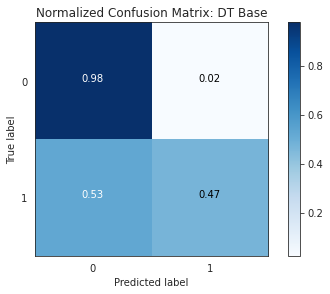

In [ ]:
print("--------Decision Tree Baseline--------")
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
print(sum(y_predict == y_test))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: DT Base')

We can see the max depth is the hyperparameter with the most significance as it determines whether the tree will overfit the data.

In [ ]:
optuna.visualization.plot_param_importances(study)